
## TW10 Unsupervised Learning

### Clustering

Basic use of common clustering models

- K-means

- DBSCAN



### Set up

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import seaborn as sn
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clustering_kmeans"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Utility functions

In [2]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    plt.show()

    
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

## K-means model

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.
    
    
The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

### 1. A synthetic dataset

This example creates a synthetic dataset with make_blobs, then applies k-means to find 3 clusters, and plots the points in each cluster identified by a corresponding color.

#### Generate a dataset

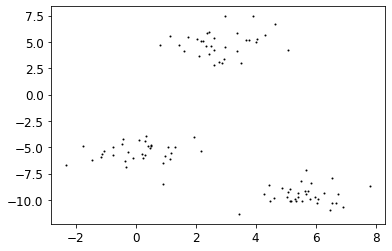

In [17]:
from sklearn.datasets import make_blobs

rand_state = 10

X, y = make_blobs(random_state = rand_state)

plot_data(X)

#### K-means model

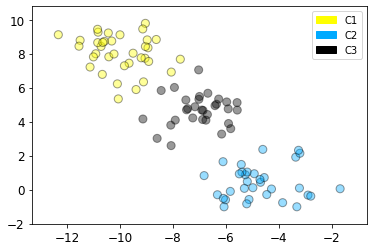

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2', 'C3'])


### 2. Real dataset: Fruit dataset

#### Load the data

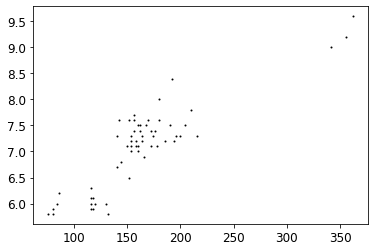

In [18]:
fruits = pd.read_csv('./data/fruit_data_with_colors.txt', sep='\t', engine='python')

X_fruits = fruits[['mass','width','height', 'color_score']].values
y_fruits = fruits[['fruit_label']] - 1


# plot the data (only use 2 attributes, 'mass', 'width')

plot_data(X_fruits)

#### Standarizing the data (scaling)

- Note that in general, it's important to scale the individual features before applying k-means clustering.

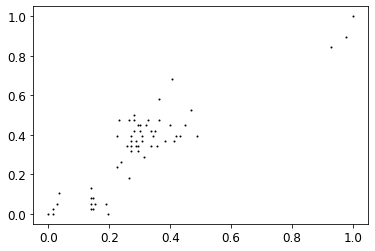

In [25]:
from sklearn.preprocessing import MinMaxScaler

X_normalized = MinMaxScaler().fit(X_fruits).transform(X_fruits)

plot_data(X_normalized)

#### K-means model

- This example showing k-means used to find 4 clusters in the fruits dataset.

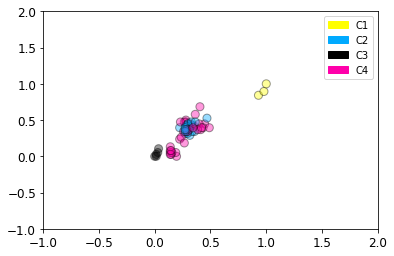

In [30]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_normalized)

plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2', 'C3', 'C4'])



## k-means vs. DBSCAN clustering

### 1. A simple dataset

#### Generate a dataset

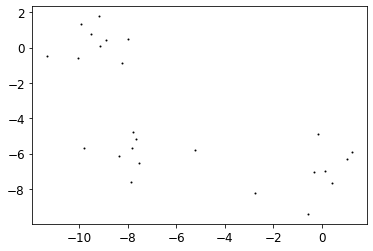

In [32]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state = 9, n_samples = 25)

plot_data(X)

#### K-means model

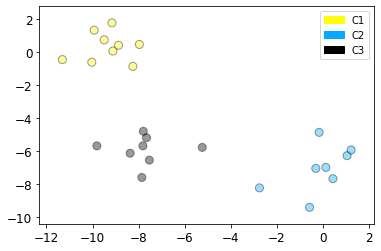

In [34]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2', 'C3'])





#### DBSCAN model

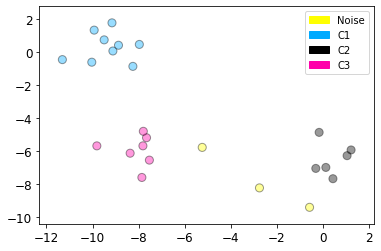

In [38]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps = 2, min_samples= 2)
cls = dbscan.fit_predict(X)

plot_labelled_scatter(X, cls + 1, ['Noise', 'C1', 'C2', 'C3'])





### 2. A more complicated dataset

#### Generate a synthetic dataset

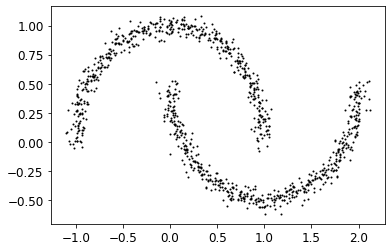

In [39]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

plot_data(X)

## Part 1

### (1) Apply the following clustering models on the generated data above. 

- K-means

- DBSCAN

#### K-means model


- Apply k-means model

- use k = 2

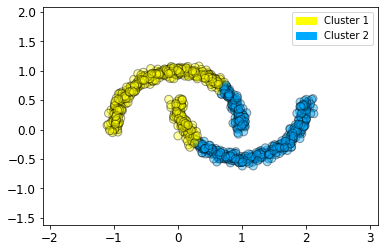

In [40]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['Cluster 1', 'Cluster 2'])

#### DBSCAN model

- Apply DBSCAN model

- use eps=0.2, min_samples=5

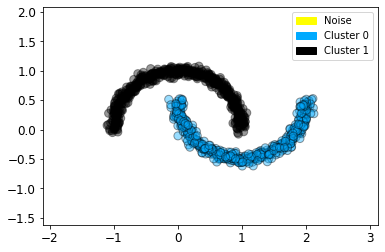

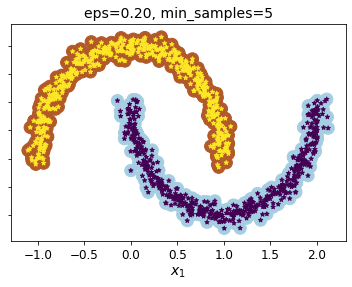

In [44]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
cls = dbscan.fit_predict(X)

plot_labelled_scatter(X, cls + 1, ['Noise', 'Cluster 0', 'Cluster 1'])

plot_dbscan(dbscan, X, size=150, show_ylabels=False)

## Part 1

### (2) Apply k-means model on breast cancer dataset and check the model performance

- check also notebook, clustering_Kmeans.ipynb for implementation details of k-means model

#### load the data

- load breat cancer dataset from sklearn.datasets (set the parameter, return_X_y = True)

- print the first five X values

- print the first five y values

In [ ]:
from sklearn.datasets import load_breast_cancer

# Breast cancer dataset
cancer = load_breast_cancer()

(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)


print(X_cancer[:5])
print(y_cancer[:5])

#### scaling the data

- scale X values using MinMaxScaler()

- print the normalized (scaled) values of the first five X

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_normalized = MinMaxScaler().fit(X_cancer).transform(X_cancer)  

print(X_normalized[:5])

#### K-means model

- Apply k-means model with k = 2

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_normalized)

y_predicted = kmeans.predict(X_normalized)

y_predicted

#### Model performance

- print the sum of all correctly predicted data (y_predicted==y_cancer)

- Since we have y_cancer values, we compare the predicted value to its y_cancer value. The ratio of correctly predicted class can represent the accuracy of the model. 

In [ ]:
np.sum(y_predicted==y_cancer)

In [ ]:
np.sum(y_predicted==y_cancer) / len(y_predicted)

## Part 2

Run the given examples of k-means, DBSCAN and Gaussian Mixsture clustering models in the following notebooks:

- clustering_Kmeans.ipynb

- clustering_DBSCAN.ipynb

- clustering_GaussianMixture.ipynb

### Submissions:

- upload the notebook (clustering_basic.ipynb) on GitHub

- Write the link to the notebook on Canvas

### Summary

KMeans seems to work well when datasets are lineraly seperable and have significant distance between the clusters.

DBSCAN works well when items are grouped very closely together and spaced far from others. DBSCAN works better for filtering out noise.